# Импорт необходимых библиотек

In [90]:
import pandas as pd
import geopandas as gpd
import folium
import folium.plugins
import pyproj
import numpy as np
import seaborn as sns
from scipy.spatial import distance
import base64
import matplotlib.pyplot as plt
import random

In [24]:
import warnings
warnings.filterwarnings("ignore")

## Суть задания:

Необходимо прочитать .csv "test.csv" в котором записаны геоданные (информация в заголовках) в системе координат `source` (нужно будет с помощью pyproj перевести в `target` для отображения на карте с помощью библиотеки folium). Предвартельно нужно будет преобразовать df в формат geopandas.

Нужно выяснить сколько было различных проездов автомобиля (прерывания более 0.5 секунды), визуализировать эти маршруты, визуализировать графики скорости проездов.

In [25]:
df = pd.read_csv('test.csv')

In [31]:
target = pyproj.Proj("+init=EPSG:4326")
source = pyproj.Proj("+init=EPSG:32637")
df['Latitude'], df['Longitude'] = pyproj.transform(source, target, list(df['X']),list(df['Y']))

In [32]:
gdf = gpd.GeoDataFrame(df)

In [33]:
polylist = []
speed = []
for i, stream_num in enumerate(gdf['panoram stream number'].unique()):
    polylinedf = df.loc[gdf['panoram stream number'] == stream_num]
    polylinedf['speed'] = ((polylinedf[['X','Y','Z']].diff() ** 2).sum(axis=1)) ** 0.5 / polylinedf['GPS time'].diff() * 3.6
    polylist.append(polylinedf)

In [34]:
polylist[0]

,Unnamed: 0,panoram stream number,frame name,GPS time,X,Y,Z,roll,pitch,heading,date time,Longitude,Latitude,speed
0,0,36,ladybug_panoramic_000000,372238.374093,399070.538384,6.186249e+06,177.289079,178.355788,178.465146,13.182995,2020-11-12 07:23:58,55.811275,37.389467,NaN
1,1,36,ladybug_panoramic_000001,372238.874115,399072.484287,6.186258e+06,177.252496,178.469506,178.115046,13.246203,2020-11-12 07:23:58,55.811356,37.389495,65.900996
2,2,36,ladybug_panoramic_000002,372239.374138,399074.437530,6.186267e+06,177.218097,178.502584,178.319568,13.085446,2020-11-12 07:23:59,55.811438,37.389522,66.847744
3,3,36,ladybug_panoramic_000003,372239.874160,399076.386642,6.186276e+06,177.172916,178.456564,177.944437,12.959536,2020-11-12 07:23:59,55.811521,37.389550,67.523825
4,4,36,ladybug_panoramic_000004,372240.374182,399078.315928,6.186285e+06,177.127745,178.859275,178.618339,12.458477,2020-11-12 07:24:00,55.811604,37.389578,68.252316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,57,36,ladybug_panoramic_000057,372266.875367,399173.201627,6.186762e+06,169.079190,178.696118,-179.534623,12.414035,2020-11-12 07:24:26,55.815910,37.390914,62.922910
58,58,36,ladybug_panoramic_000058,372267.375389,399174.921776,6.186771e+06,168.820853,178.483045,-179.623424,12.250150,2020-11-12 07:24:27,55.815987,37.390938,62.632922
59,59,36,ladybug_panoramic_000059,372267.875412,399176.613606,6.186779e+06,168.562510,178.559326,-179.505842,11.993371,2020-11-12 07:24:27,55.816063,37.390962,62.383664
60,60,36,ladybug_panoramic_000060,372268.375434,399178.252314,6.186788e+06,168.304836,178.418475,-179.589118,11.810852,2020-11-12 07:24:28,55.816140,37.390985,62.071850


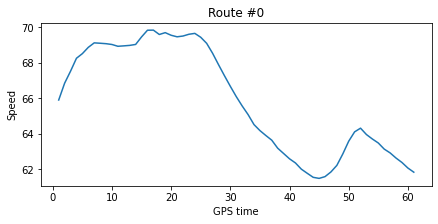

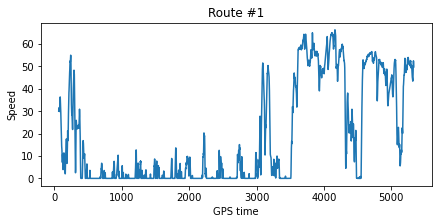

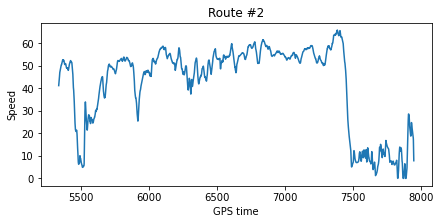

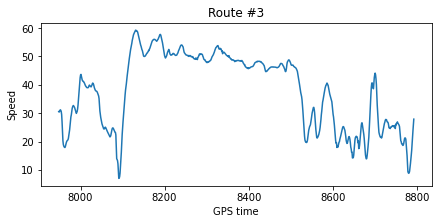

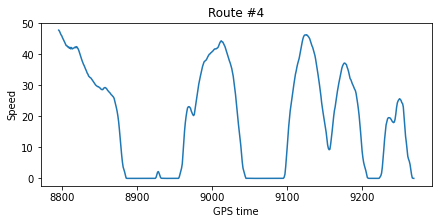

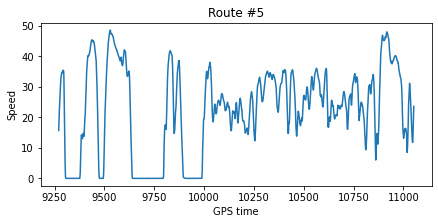

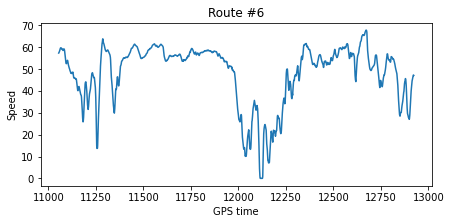

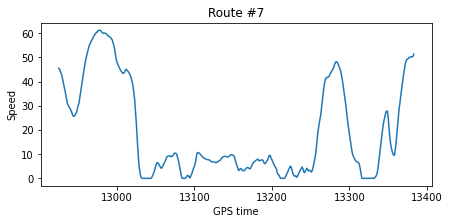

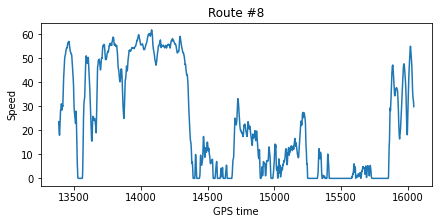

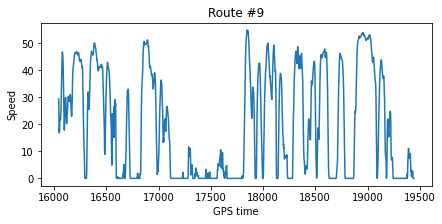

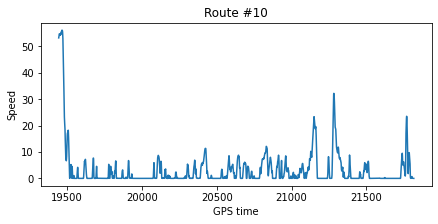

In [95]:
random.seed(0)

moscow_map = folium.Map(location=[55.81, 37.50], zoom_start=12)

resolution, width, height = 75, 7, 3

for i, poly in enumerate(polylist):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
    fig, ax = plt.subplots(figsize=(width, height))
    ax = poly['speed'].plot(ax=ax, legend=False)
    ax.set_title(f'Route #{i}')
    ax.set_ylabel('Speed')
    ax.set_xlabel('GPS time')
    png = 'mpld3_{}.png'.format(i)
    fig.savefig(png, dpi=resolution)

    encoded = base64.b64encode(open(png, 'rb').read())
    html = '<img src="data:image/png;base64,{}">'.format
    iframe = IFrame(html(encoded.decode('UTF-8')), width=(width*resolution)+20, height=(height*resolution)+20)
    popup = folium.Popup(iframe, max_width=2650)
    folium.plugins.AntPath(np.c_[poly['Longitude'], poly['Latitude']], color=color, popup=popup, delay=1000).add_to(moscow_map)
    

In [96]:
moscow_map